In [20]:
import geopandas as gpd
import huracanpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from tqdm import tqdm
import xarray as xr


In [34]:
japan = pd.read_csv("~/john/Areas_JKH/Japan_1.0.csv", delimiter=" ", header=None, names=["lon", "lat"])
usa = pd.read_csv("~/john/Areas_JKH/USA_all.csv", delimiter=" ", header=None, names=["lon", "lat"])

usa_gulf_mexico = pd.read_csv("~/john/Areas_JKH/USA1_gulf_mexico.csv", delimiter=" ", header=None, names=["lon", "lat"])
usa_florida = pd.read_csv("~/john/Areas_JKH/USA2_florida_1.1.csv", delimiter=" ", header=None, names=["lon", "lat"])
usa_north = pd.read_csv("~/john/Areas_JKH/USA3_North.csv", delimiter=" ", header=None, names=["lon", "lat"])

B = dict(
    Japan=Polygon([(lon, lat) for lon, lat in zip(japan.lon, japan.lat)]),
    USA=Polygon([(lon, lat) for lon, lat in zip(usa.lon, usa.lat)]),
)
huracanpy.basins["cgfi"] = gpd.GeoDataFrame(index=B.keys(), geometry=list(B.values()))

B = dict(
    usa_gulf_mexico=Polygon([(lon, lat) for lon, lat in zip(usa_gulf_mexico.lon, usa_gulf_mexico.lat)]),
    usa_florida=Polygon([(lon, lat) for lon, lat in zip(usa_florida.lon, usa_florida.lat)]),
    usa_north=Polygon([(lon, lat) for lon, lat in zip(usa_north.lon, usa_north.lat)]),
)
huracanpy.basins["cgfi_gate"] = gpd.GeoDataFrame(index=B.keys(), geometry=list(B.values()))

from huracanpy.info import _geography
from importlib import reload

reload(_geography)

<module 'huracanpy.info._geography' from '/home/users/train187/miniforge3/envs/core/lib/python3.13/site-packages/huracanpy/info/_geography.py'>

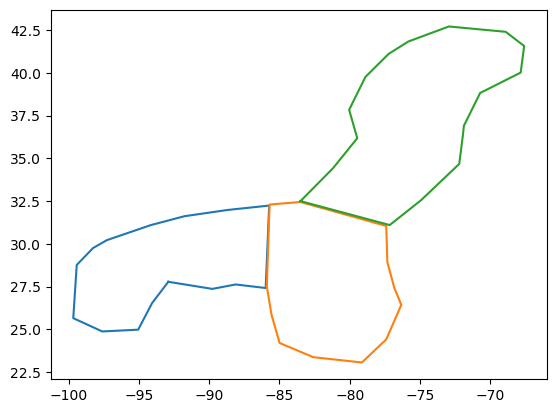

In [35]:
plt.plot(usa_gulf_mexico.lon, usa_gulf_mexico.lat)
plt.plot(usa_florida.lon, usa_florida.lat)
plt.plot(usa_north.lon, usa_north.lat)

In [11]:
tracks = huracanpy.load("../tracks/depresys/depresys_tcs_01-year-lead.nc")

In [45]:
tracks = tracks.hrcn.add_ace(wind_name="vmax10m", threshold=0)
tracks, _ = tracks.hrcn.add_pace(pressure_name="mslp", wind_threshold=0, model="z2021")
tracks["cgfi_region"] = tracks.hrcn.get_basin(convention="cgfi")
#tracks["cgfi_gate"] = tracks.hrcn.get_basin(convention="cgfi_gate")
tracks["ssi"] = tracks.vmax10m ** 3

In [46]:
per_track_stats = tracks[["ace", "pace", "ssi", "precip"]].groupby(tracks.track_id).sum()
track_max_intensity = tracks.hrcn.get_apex_vals("vmax10m")

per_track_stats["time"] = track_max_intensity["time"]
per_track_stats["start_year"] = track_max_intensity["start_year"]
per_track_stats["ensemble_member"] = track_max_intensity["ensemble_member"]
per_track_stats["basin"] = track_max_intensity.hrcn.get_basin()

In [47]:
per_track_stats.to_netcdf("../tracks/depresys/depresys_tc_stats_01-year-lead_all.nc")

In [48]:
for cgfi_region in "Japan", "USA":
    ids_region = np.unique(tracks.track_id[tracks.cgfi_region == cgfi_region])
    per_track_stats.hrcn.sel_id(ids_region).to_netcdf(f"../tracks/depresys/depresys_tc_stats_01-year-lead_{cgfi_region}.nc")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [23]:
tracks = xr.open_dataset("../tracks/depresys/depresys_tc_stats_01-year-lead_Japan.nc")

tracks = tracks.hrcn.sel_id(tracks.track_id[(tracks.time.dt.month >= 6) & (tracks.time.dt.month <= 11)])

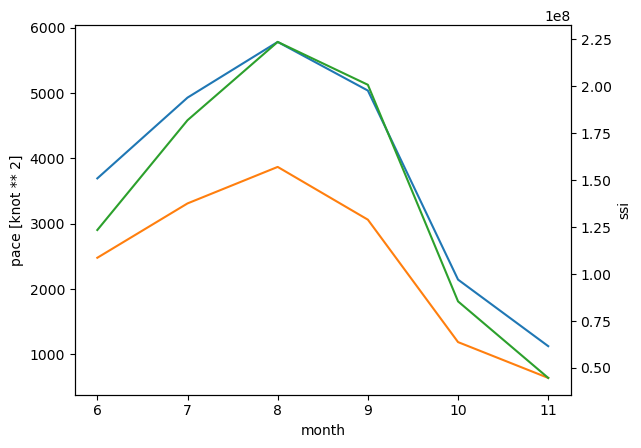

In [32]:
tracks.ace.groupby(tracks.time.dt.month).sum().plot()
tracks.pace.groupby(tracks.time.dt.month).sum().plot()
plt.twinx()
tracks.ssi.groupby(tracks.time.dt.month).sum().plot(color="C2")